## Hands classification

* In this notebook there are recordings of 3 hands movement situations.
* i will try to classify them into those situations acording to their position, velocity and more.
* The situations are:
    * Spontaneous- two people moving freely their hands while sitting together.
    * synchronous- two people moving their hands while sitting together, trying to be synchronized.
    * Alone- one person moving freely his hand.


### Import libraries

In [875]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from pandas import Series
# models part
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA   
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
import xgboost
import xgboost as xgb
from sklearn import metrics
# warnings
import warnings
warnings.filterwarnings('ignore')
import os
import math

### The data preparation takes a lot of steps, so i decided to build function with help functions inside to prepar the data, and i explaind every step.

In [876]:
# Import the data and organize it in 3 lists:spontan, sync, alone
def build(file):
    paricipants=file
    spon_list = []
    sync_list = []
    alone_list = []
    for i, participant in enumerate(paricipants):
        participants_files = glob.glob(participant + "/*.csv") 
        for file in participants_files:
            temp=drop_7_sec(file)
#             temp = pd.read_csv(file)
#             time_to_drop=math.ceil(temp["Time"][0])+7
#             temp=temp[temp["Time"]>time_to_drop]
            if file.endswith('Spontan.csv'):
                spon= temp
                spon_list.append(spon)
            elif file.endswith('Sync.csv'):
                sync= temp
                sync_list.append(sync)
            elif file.endswith('Alone.csv'):
                alone= temp
                alone_list.append(alone)
# concat the recordings according to their list, and create data frames of the lists
    df_spon = pd.concat(spon_list, axis=0, ignore_index=True)
    df_sync = pd.concat(sync_list, axis=0, ignore_index=True)
    df_alone = pd.concat(alone_list, axis=0, ignore_index=True)
# Create labels in every df    
    df_spon,df_sync,df_alone=la(df_spon,df_sync,df_alone)
# remove first 7 seconds from each recording    
#     df_spon,df_sync,df_alone=sec(df_spon,df_sync,df_alone)
# now i took care of 2 hands situation and after in 1 hand situation: first, concat spon and sync
    df_sposyn=con_sy_sp(df_spon,df_sync)
# dropp all the rows with feature 'hands'=1     
    df_sposyn=drop_hand(df_sposyn)
# split the data according to type of hand and merge it so every frame will be in one row and diminish by taking every 20 frame
    df_sposyn=right_left_comb(df_sposyn)
# one hand situation: merge alone and hand right so every frame in the alone data will have pair from the right hand data
    df_hr=pd.read_csv("C:/Users/97254/.conda/Handright.csv")
    df_alone= df_alone[df_alone.index % 25 == 0].reset_index(drop=True)
    df1=pd.merge(df_alone, df_hr,on=['Time',' Frame ID',' # hands'],left_index=True, right_index=True).reset_index(drop=True)
# concat the 2 data frames into one    
    df=pd.concat([df1,df_sposyn])
# change 'hand type' to numeric value    
    df[" Hand Type_x"]=Series([1 if i=="right" else 2 for i in df[" Hand Type_x"]])
    df[" Hand Type_y"]=Series([1 if i=="right" else 2 for i in df[" Hand Type_y"]])
    
    return df

#### Create training set

In [877]:
df=build(glob.glob(r'C:/Users/97254/.conda/Training/' + "/*"))   
df

,Time,Frame ID,Hand Type_x,# hands,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,526.0007,150449,2,1,-46.60518,178.0750,-18.757020,5.439669,96.98898,-12.102810,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.45530,0.0,0.206389,0.0
1,526.4149,150497,2,1,-82.92123,206.1454,6.357242,73.156590,-164.49430,-71.277480,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.44820,0.0,0.243050,0.0
2,526.8290,150545,2,1,-40.35501,199.8350,-10.003570,-14.615530,71.37882,-3.077893,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.85440,0.0,0.281134,0.0
3,527.2432,150592,2,1,-103.88840,218.4056,48.730380,77.108100,-427.12250,62.248640,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.09270,0.0,0.277691,0.0
4,527.6577,150640,2,1,-41.71663,161.0002,7.274406,62.083510,167.93760,64.759570,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.28960,0.0,0.283008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,852.4635,67064,2,2,-83.90349,205.9792,-15.932530,14.235290,-26.48535,-12.246520,...,-2.168338,123.04620,133.6873,31.53965,289.0648,-64.91495,30.21533,0.0,0.000000,0.0
2677,853.2994,67116,2,2,-58.35790,159.9274,-15.694900,43.164900,-28.28878,-7.025205,...,-0.406183,120.45850,133.9525,45.90549,296.4559,-5.98533,174.15970,0.0,0.000000,0.0
2678,854.1303,67169,2,2,-68.45061,169.1186,-12.996980,25.174220,136.32030,-12.358740,...,-0.398261,125.87150,142.2466,54.52624,304.9686,-14.97589,155.58140,0.0,0.000000,0.0
2679,854.9633,67224,2,2,-77.49830,203.5687,0.131859,-10.814190,-18.57390,-30.342760,...,-1.956911,124.23340,139.1985,49.55933,302.6661,-48.31174,46.65322,0.0,0.000000,0.0


In [878]:
df.shape

(4074, 42)

In [879]:
df_test=build(glob.glob(r'C:/Users/97254/.eclipse/Validation/' + "/*"))

In [880]:
def drop_7_sec(path):
    df = pd.read_csv(path)
    time_to_drop=math.ceil(df["Time"][0])+7
    df=df[df["Time"]>time_to_drop]
    return df

### remove first 7 seconds from each recording   

In [881]:
def sec(df_spon,df_sync,df_alone):
    df_spon= (df_spon[df_spon["Time"] > (df_spon["Time"][0] + 7)])
    df_sync= (df_sync[df_sync["Time"] > (df_sync["Time"][0] + 7)])
    df_alone= (df_alone[df_alone["Time"] > (df_alone["Time"][0] + 7)])
    return df_spon,df_sync,df_alone

### Create labels in every df

In [882]:
def la(df_spon,df_sync,df_alone):
    df_spon['label']=0
    df_sync['label']=1
    df_alone['label']=2
    return df_spon,df_sync,df_alone

### now i took care of 2 hands situation: first, concat spon and sync and reset indexes (because i dropped first 7 seconds)

In [883]:
def con_sy_sp(df_spon,df_sync):
    df_sposyn= pd.concat([df_spon,df_sync])
    df_sposyn.reset_index()
    return df_sposyn

###  drop all the rows with feature 'hands'=1: I checked with 'value_counts' if there are frames with only one hand and dropped them because we are in the dataframe of 2 hands situation

In [884]:
def drop_hand(df_sposyn):
    i=df_sposyn.loc[df_sposyn[' # hands']==1].index
    df_sposyn=df_sposyn.drop(i)
    return df_sposyn

### Because every frame has 2 rows (right and left) i merged the frames to one row by split the data to two, according to 'hand type'. Then merge to one row so that only frames which have both hands will include (inner).

### Second thing i did is to decrease data, because the frame's times is so closed(difference of about 0.015 beetween the frames) so the movement is neglectible. so i took every 25 frame(about 0.5 second difference) 

In [885]:
def right_left_comb(df_sposyn):    
    df_sposyn_left=df_sposyn[df_sposyn[' Hand Type']=='left']
    df_sposyn_right=df_sposyn[df_sposyn[' Hand Type']=='right']
    df_sposyn=pd.merge(df_sposyn_left,df_sposyn_right,on=['Time',' Frame ID',' # hands','label'],how='inner')
    df_sposyn=df_sposyn[df_sposyn.index % 25 == 0].reset_index(drop=True)
    return df_sposyn

Text(0, 0.5, 'X pos left')

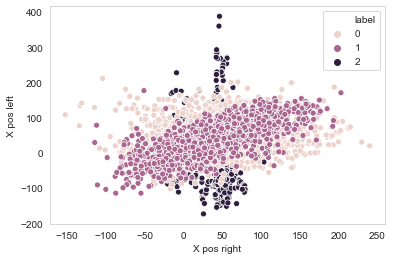

In [886]:
sns.scatterplot(x=" Position Z_y", y=" Position Z_x", hue="label", data=df)
plt.xlabel('X pos right')
plt.ylabel('X pos left')

Text(0.5, 0, 'Left Position Z')

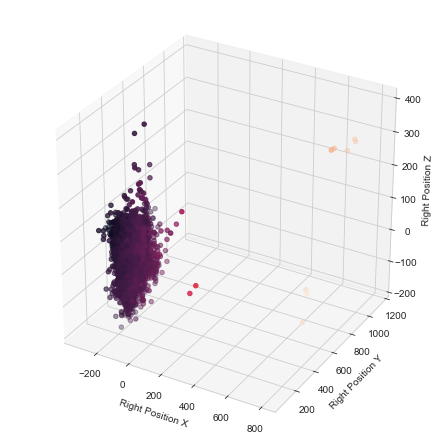

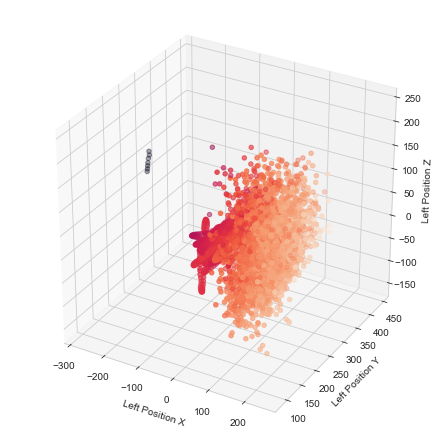

In [887]:
sns.set_style("whitegrid", {'axes.grid' : False})

fig1 = plt.figure(figsize=(6,6))
ax = Axes3D(fig1) 
x1 = df[' Position X_x']
y1 = df[' Position Y_x']
z1 = df[' Position Z_x']
ax.scatter(x1, y1, z1, c=x1, marker='o')
ax.set_xlabel('Right Position X')
ax.set_ylabel('Right Position Y')
ax.set_zlabel('Right Position Z')

fig2 = plt.figure(figsize=(6,6))
ax = Axes3D(fig2) 
x2 = df[' Position X_y']
y2 = df[' Position Y_y']
z2 = df[' Position Z_y']
ax.scatter(x2, y2, z2, c=x2, marker='o')
ax.set_xlabel('Left Position X')
ax.set_ylabel('Left Position Y')
ax.set_zlabel('Left Position Z')

In [888]:
df.drop(['Time',' Frame ID',' # hands'],axis=1)

,Hand Type_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,Yaw_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,2,-46.60518,178.0750,-18.757020,5.439669,96.98898,-12.102810,0.670744,2.865586,1.276748,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.45530,0.0,0.206389,0.0
1,2,-82.92123,206.1454,6.357242,73.156590,-164.49430,-71.277480,1.182864,-3.083286,1.358358,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.44820,0.0,0.243050,0.0
2,2,-40.35501,199.8350,-10.003570,-14.615530,71.37882,-3.077893,0.895151,1.811641,1.050796,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.85440,0.0,0.281134,0.0
3,2,-103.88840,218.4056,48.730380,77.108100,-427.12250,62.248640,1.170061,0.297046,1.454513,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.09270,0.0,0.277691,0.0
4,2,-41.71663,161.0002,7.274406,62.083510,167.93760,64.759570,1.310517,0.409162,1.449638,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.28960,0.0,0.283008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,2,-83.90349,205.9792,-15.932530,14.235290,-26.48535,-12.246520,1.336503,1.406869,0.769383,...,-2.168338,123.04620,133.6873,31.53965,289.0648,-64.91495,30.21533,0.0,0.000000,0.0
2677,2,-58.35790,159.9274,-15.694900,43.164900,-28.28878,-7.025205,0.703169,1.740336,0.606227,...,-0.406183,120.45850,133.9525,45.90549,296.4559,-5.98533,174.15970,0.0,0.000000,0.0
2678,2,-68.45061,169.1186,-12.996980,25.174220,136.32030,-12.358740,0.641901,1.781092,0.512229,...,-0.398261,125.87150,142.2466,54.52624,304.9686,-14.97589,155.58140,0.0,0.000000,0.0
2679,2,-77.49830,203.5687,0.131859,-10.814190,-18.57390,-30.342760,1.160698,1.446287,0.526926,...,-1.956911,124.23340,139.1985,49.55933,302.6661,-48.31174,46.65322,0.0,0.000000,0.0


#### Train-test split

In [889]:
y = df['label']
X = df.drop(['label'], axis=1)


In [890]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=42)

In [891]:
X_tests=df_test.drop(['label'], axis = 1)
y_tests=df_test['label']

In [892]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_reduced_tes = scaler.transform(X_tests)

In [893]:
# pca
pca = PCA(n_components=15)
X_train_reduced = pca.fit_transform(X_train)
#transform also the test set
X_val_red=pca.transform(X_val)
X_reduced_tes = pca.transform(X_reduced_tes)

### Modeling

* First, train the models on the training set and check the best parameters for some models using GridSearchCv
* Then, evaluate on the test set
* Finally, after finishing train the models on the test set, check them on the validation set 

In [894]:
def result(model):
    res=  Pipeline([('model', model)])
    res.fit(X_train_reduced, y_train)
    print(round(res.score(X_val_red,y_val)*100,4),"%")

    

### Knn

In [971]:
param_grid_knn=[{'n_neighbors': [5,7,10,16,22],'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
model=KNeighborsClassifier()
grid_search_knn=GridSearchCV(model,param_grid_knn,cv=5,scoring='accuracy')
grid_search_knn.fit(X_train_reduced, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'n_neighbors': [5, 7, 10, 16, 22]}],
             scoring='accuracy')

In [972]:
grid_search_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 10}

In [973]:
knn = KNeighborsClassifier(n_neighbors = 10)
result(knn)

94.0311 %


### Random forrest

In [898]:
param_grid_rf=[{'n_estimators':[100,150,175,200,225],'max_depth':[7,12,15,18,20]}]
model=RandomForestClassifier()
grid=GridSearchCV(model,param_grid_rf,cv=3,scoring='accuracy')
grid.fit(X_train_reduced, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [7, 12, 15, 18, 20],
                          'n_estimators': [100, 150, 175, 200, 225]}],
             scoring='accuracy')

In [899]:
grid.best_params_

{'max_depth': 18, 'n_estimators': 200}

In [900]:
rf = RandomForestClassifier(max_depth=20, n_estimators=175)
result(rf)

93.704 %


### Logistic regression

In [901]:
param_grid_lr=[{'penalty':['l1', 'l2','elasticnet','none'],'C': [0.1, 0.5, 1, 5, 10, 50, 100]}]
model=LogisticRegression()
grid_lr=GridSearchCV(model,param_grid_lr,cv=3,scoring='accuracy')
grid_lr.fit(X_train_reduced, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 0.5, 1, 5, 10, 50, 100],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none']}],
             scoring='accuracy')

In [902]:
grid_lr.best_params_

{'C': 1, 'penalty': 'l2'}

In [903]:
lr = LogisticRegression(penalty= 'l2',C=0.1)
result(lr)

88.471 %


### Xgboost

In [904]:
param_grid_xg=[{'n_estimators':[160,180,200,220,240],'learning_rate':[0.2,0.5,1,1.5,2]}]
model=XGBClassifier(eval_metric='mlogloss')
grid_search_xg=GridSearchCV(model,param_grid_xg,cv=2,scoring='accuracy')
grid_search_xg.fit(X_train_reduced, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

In [905]:
grid_search_xg.best_params_

{'learning_rate': 0.5, 'n_estimators': 240}

In [975]:
xgb = XGBClassifier(eval_metric='mlogloss', learning_rate = 0.5, n_estimators= 240)
result(xgb)

95.1758 %


### Stacking

In [976]:
stacking=StackingClassifier([
        ('rf', RandomForestClassifier(max_depth=20,n_estimators= 225)),    
        ('knn', KNeighborsClassifier(n_neighbors=5,algorithm='auto'),
        ('xgb', XGBClassifier(eval_metric='mlogloss', learning_rate=0.5, n_estimators=240))
        )])
result(stacking)

94.8487 %


In [908]:
df_test.drop(['Time',' Frame ID',' # hands'],axis=1)

,Hand Type_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,Yaw_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,2,40.41911,194.2201,21.29477,-32.302420,0.189444,-54.70464,0.698933,-2.968176,1.246851,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,2,-22.28859,252.8564,39.10022,-227.576900,215.248800,61.59812,1.139781,-2.315936,0.996171,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,2,-77.73283,265.5974,63.97878,-116.560000,-56.360250,49.24916,1.143665,0.609194,1.290360,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,2,-142.19550,258.2204,79.75294,-258.714800,-12.179600,12.66394,1.233569,0.433647,1.403293,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,2,-178.47400,258.8552,79.68269,258.774900,-145.161600,-58.11039,1.368628,0.493161,1.466882,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,2,-126.71670,238.2905,93.64916,-83.103610,-58.129790,-49.92599,1.008779,0.414681,1.292194,...,-1.175451,117.23910,210.7587,180.55230,335.9680,69.00294,235.8746,0.0,0.148278,0.0
792,2,-79.74459,287.6227,51.88764,-76.990880,83.765250,113.92610,1.345698,0.651067,1.401338,...,-1.309565,205.36990,211.2587,93.60893,385.4841,22.77898,148.6449,0.0,0.000000,0.0
793,2,-88.26382,299.8587,94.23167,101.100200,162.285400,-18.73653,1.597519,1.130905,1.628316,...,-1.456240,156.94980,284.9480,106.94010,341.6207,94.37777,129.5167,0.0,0.000000,0.0
794,2,-79.27560,294.8668,84.57072,2.953028,-358.944300,-26.47951,1.612317,0.979432,1.633340,...,-1.459679,185.05540,199.0112,98.83315,406.2700,55.31898,135.4422,0.0,0.000000,0.0


### Testing

In [909]:
def result10000(model):
#     res=  Pipeline([('model', model)])
    model.fit(X_train_reduced, y_train)
    print(round(model.score(X_reduced_tes,y_tests)*100,4),"%")

In [974]:
knn = KNeighborsClassifier(n_neighbors = 10,algorithm='auto')
result10000(knn)

85.8794 %


In [980]:
xgb = XGBClassifier(eval_metric='mlogloss', learning_rate = 0.5, n_estimators= 240)
result10000(xgb)

77.7044 %


In [981]:
stacking=StackingClassifier([
        ('rf', RandomForestClassifier(max_depth=20,n_estimators= 225)),    
        ('knn', KNeighborsClassifier(n_neighbors=10,algorithm='auto'),
        ('xgb', XGBClassifier(eval_metric='mlogloss', learning_rate=0.5, n_estimators=240))
        )])
result10000(stacking)

85.0537 %


In [913]:
lr = LogisticRegression(penalty= 'l2',C=0.1)
result10000(lr)

75.7225 %


In [914]:
rf = RandomForestClassifier(max_depth=20, n_estimators=175)
result10000(rf)

81.9158 %


In [915]:
voting = VotingClassifier(estimators=[('knn', knn), ('rfc', rf), ('xgb', xgb)],voting='hard')
result10000(voting)

81.9983 %
